In [71]:
import os
import numpy as np
import polars as pl
import joblib
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import cm

import sys
# to be changed after release!!!
sys.path.append('/mnt/mlshare/prasse/aeye_git/pymovements/src/')
import preprocessing.feature_extraction as feature_extraction
import config.config as config
import utils.helpers as helpers

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
save_dir = 'results/'

In [3]:
def dataframe_to_latex(input_df):
    df_columns = input_df.columns
    df_dict    = dict()
    for key in df_columns:
        df_dict[key] = list(input_df[key])
    table_string = '\\begin{tabular}{' + '|'.join('l' for a in range(len(df_columns))) + '}\n \\hline\n'
    table_string += ' & '.join('\\bf{' + str(key) + '}' for key in df_columns) + '\\\\\hline \n'
    for i in range(input_df.shape[0]):
        table_string += ' & '.join(str(df_dict[key][i])  for key in df_columns) + '\\\\\hline \n'
    table_string += '\\end{tabular}' 
    return table_string

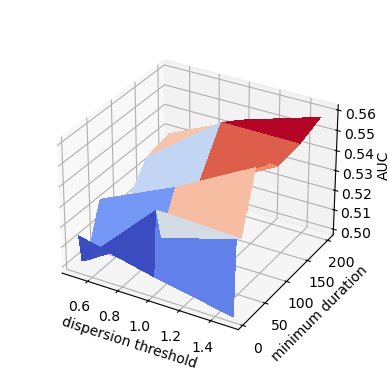

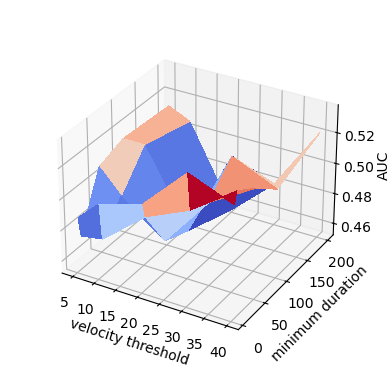

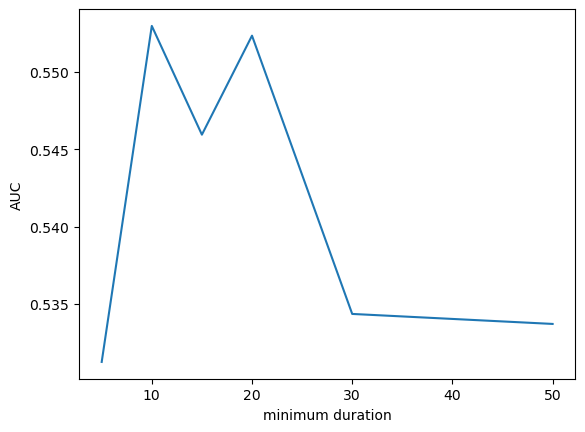

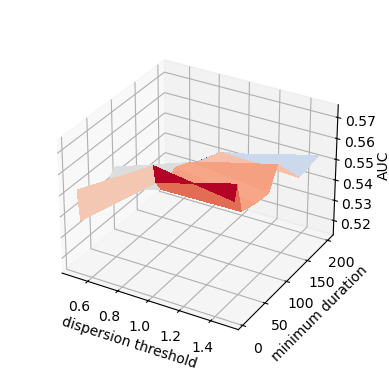

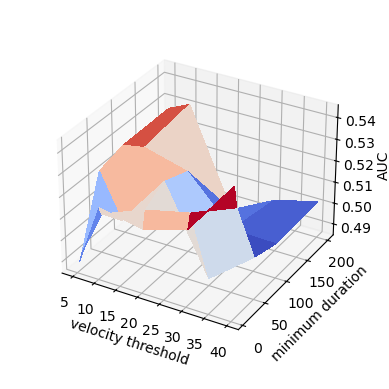

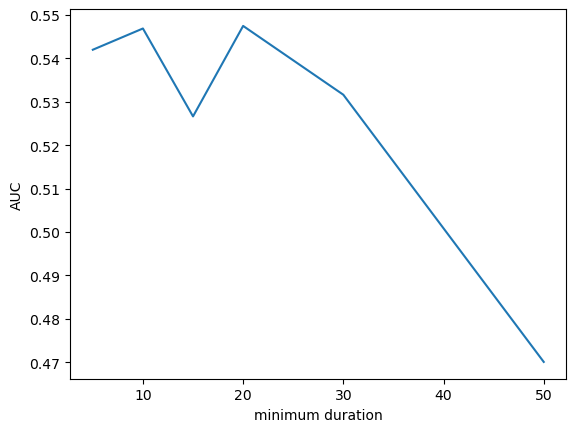

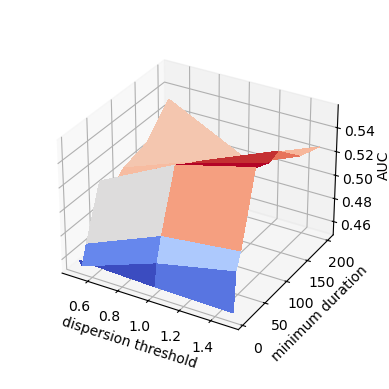

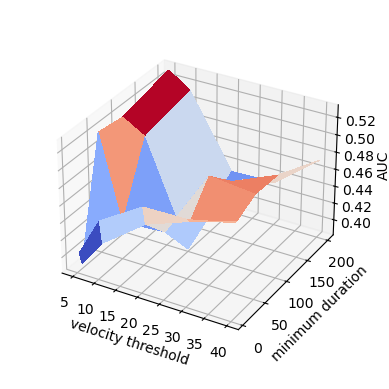

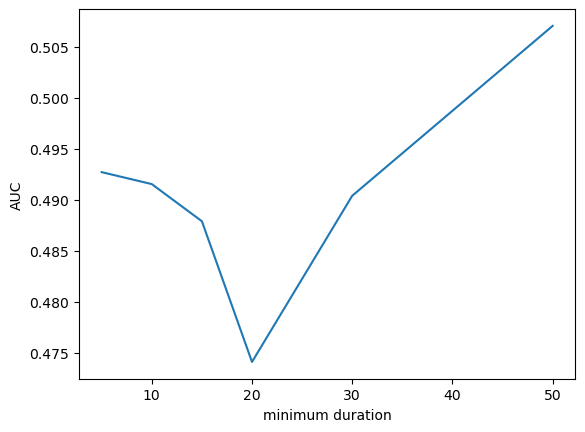

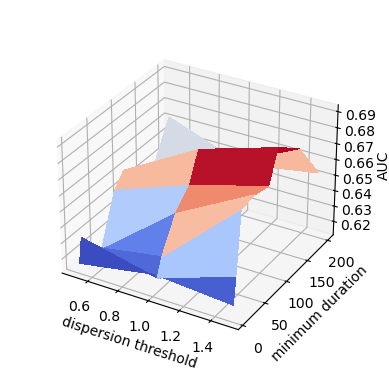

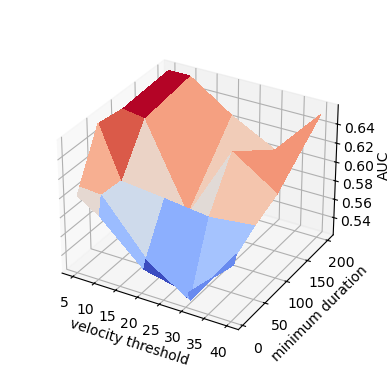

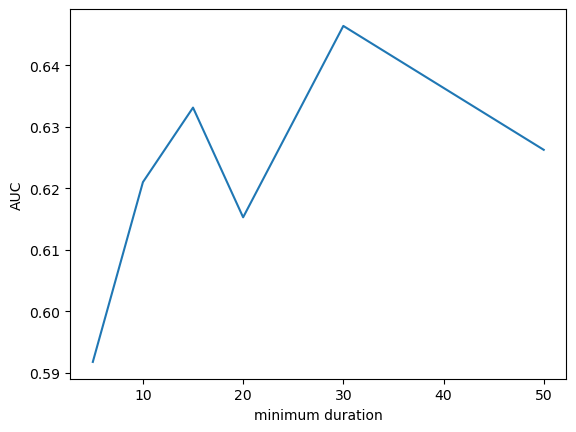

sbsat
shape: (55, 5)
┌────────────────────┬───────────────┬────────────────────┬────────────────────┬───────────────────┐
│ Detection Method   ┆ Text          ┆ Text Difficulty    ┆ General Reading    ┆ Native Speaker    │
│ ---                ┆ Comprehension ┆ ---                ┆ Comprehension      ┆ ---               │
│ str                ┆ ---           ┆ str                ┆ ---                ┆ str               │
│                    ┆ str           ┆                    ┆ str                ┆                   │
╞════════════════════╪═══════════════╪════════════════════╪════════════════════╪═══════════════════╡
│ IDT $(min_{dur}=5, ┆ 0.515 $\pm$   ┆ 0.552 $\pm$ 0.008  ┆ 0.457 $\pm$ 0.042  ┆ 0.616 $\pm$ 0.023 │
│ dis_{th}=0.…       ┆ 0.031         ┆                    ┆                    ┆                   │
│ IDT $(min_{dur}=5, ┆ 0.506 $\pm$   ┆ 0.573 $\pm$ 0.021  ┆ 0.455 $\pm$ 0.045  ┆ 0.624 $\pm$ 0.026 │
│ dis_{th}=1.…       ┆ 0.032         ┆                    ┆           

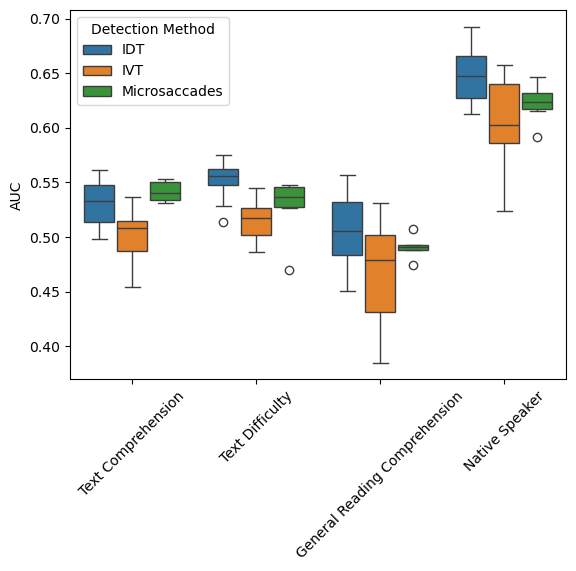

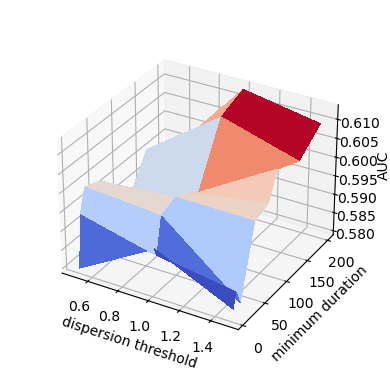

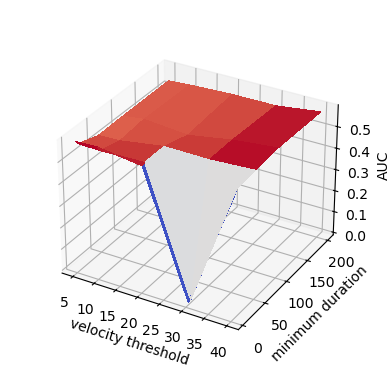

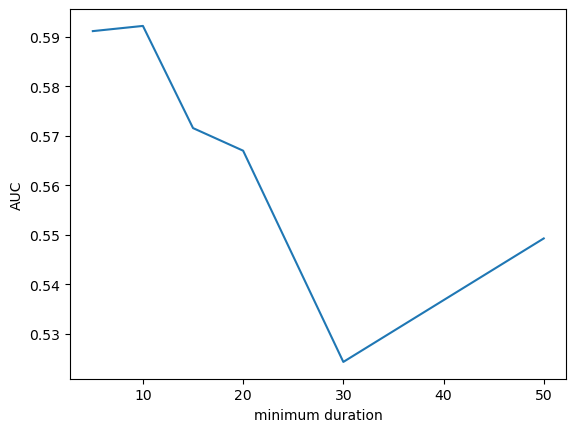

potec
shape: (55, 2)
┌─────────────────────────────────┬───────────────────┐
│ Detection Method                ┆ Text Familarity   │
│ ---                             ┆ ---               │
│ str                             ┆ str               │
╞═════════════════════════════════╪═══════════════════╡
│ IDT $(min_{dur}=5, dis_{th}=0.… ┆ 0.58 $\pm$ 0.003  │
│ IDT $(min_{dur}=5, dis_{th}=1.… ┆ 0.591 $\pm$ 0.009 │
│ IDT $(min_{dur}=5, dis_{th}=1.… ┆ 0.582 $\pm$ 0.014 │
│ IDT $(min_{dur}=10, dis_{th}=0… ┆ 0.594 $\pm$ 0.008 │
│ IDT $(min_{dur}=10, dis_{th}=1… ┆ 0.589 $\pm$ 0.01  │
│ …                               ┆ …                 │
│ Microsaccades $(min_{dur}=10)$  ┆ 0.592 $\pm$ 0.011 │
│ Microsaccades $(min_{dur}=15)$  ┆ 0.572 $\pm$ 0.012 │
│ Microsaccades $(min_{dur}=20)$  ┆ 0.567 $\pm$ 0.014 │
│ Microsaccades $(min_{dur}=30)$  ┆ 0.524 $\pm$ 0.004 │
│ Microsaccades $(min_{dur}=50)$  ┆ 0.549 $\pm$ 0.013 │
└─────────────────────────────────┴───────────────────┘
shape: (53, 3)
┌───────────

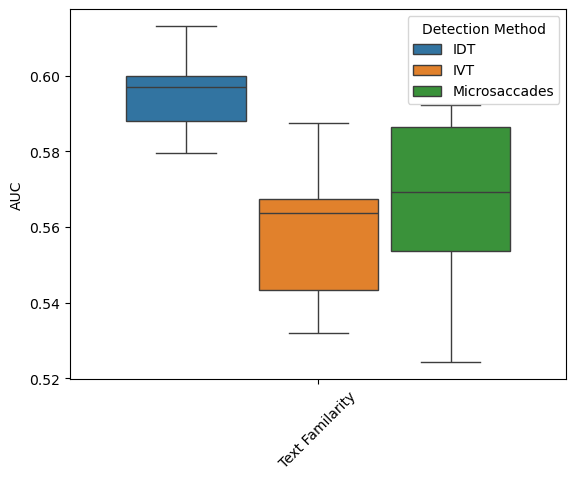

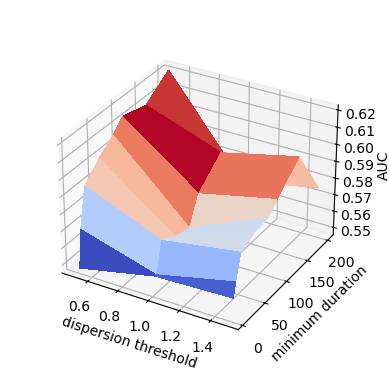

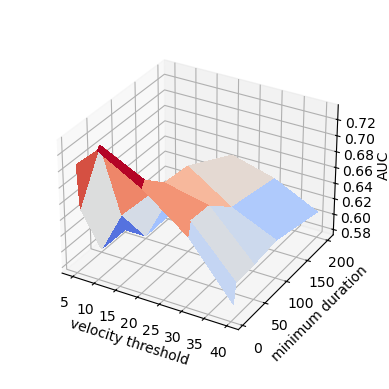

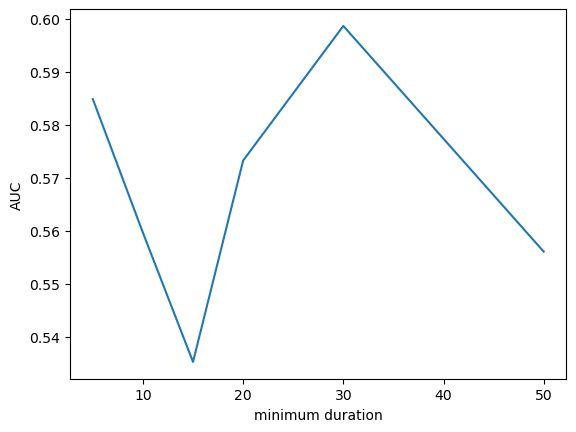

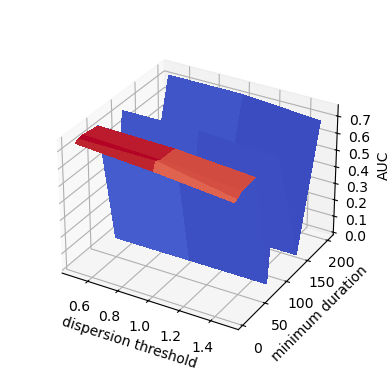

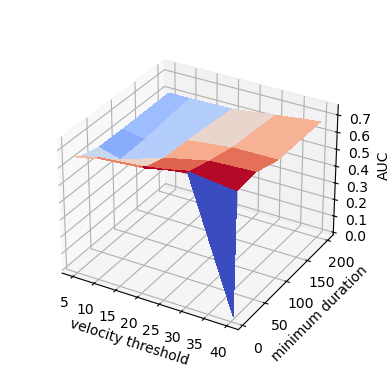

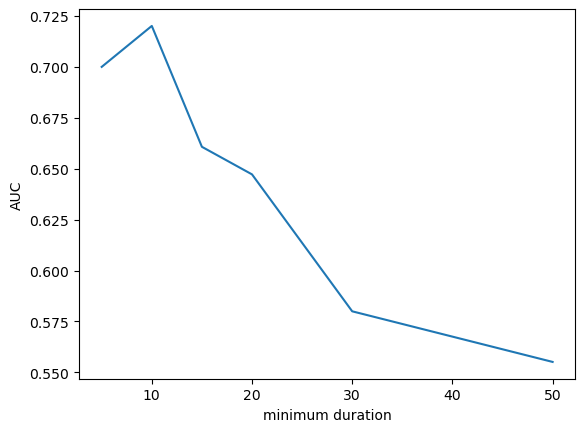

FileNotFoundError: [Errno 2] No such file or directory: 'copco_IDT_L1 with dyslexia vs. L1 w/o dyslexia vs. L2_3D.pdf'

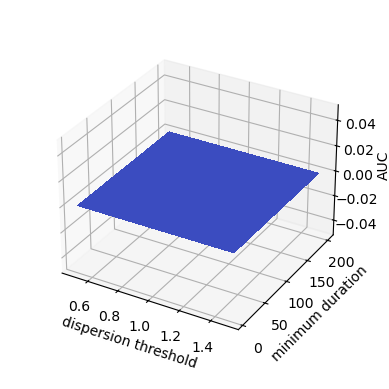

In [89]:
column_name_mapping = {'acc': 'Text Comprehension',
                       'subj_acc': 'General Reading Comprehension',
                       'difficulty': 'Text Difficulty',
                       'native': 'Native Speaker',
                       'familarity': 'Text Familarity',
                       'classes': 'L1 with dyslexia vs. L1 w/o dyslexia vs. L2',
                       'l1vsl2': 'L1 vs. L2',
                       'dyslexia': 'Dyslexia',
                       'task_name': 'Task',
                       'detection_method': 'Detection Method',
                       'label':'ADHD',
                       'gender':'Gender',
                       'task':'Task'
                      }

dataset_metric_mapping = {'sbsat':'AUC',
                          'potec':'AUC',
                          'copco':'AUC/Accuracy',
                          'gazebase':'Accuracy',
                          'gazebasevr':'Accuracy',
                          'hbn':'AUC',
                          'gazeonfaces':'AUC',
                          'gazegraph':'AUC'}

detectoin_method_mapping = {'idt':'IDT',
                            'ivt':'IVT',
                            'microsaccades':'Microsaccades',
                           }

decimals = 3
detection_methods = ['idt', 'ivt', 'microsaccades']
datasets          = ['sbsat','potec','copco','gazebase','gazebasevr','hbn','gazeonfaces','gazegraph']
for dataset in datasets:
    label_columns = helpers.get_datset_labels(dataset)
    label_counter = 0
    result_df = {column_name_mapping['detection_method']:[]}
    box_plot_df = {'Detection Method':[],
                   'Problem Setting':[],
                   dataset_metric_mapping[dataset]:[],
                  }
    for label in label_columns:
        result_df[column_name_mapping[label]] = []
        for detection_method in detection_methods:
            if dataset == 'gazebasevr':
                detection_params = helpers.get_detection_params(detection_method, sampling_rate=250)
            elif dataset == 'hbn':
                detection_params = helpers.get_detection_params(detection_method, sampling_rate=120)
            elif dataset == 'gazeonfaces':
                detection_params = helpers.get_detection_params(detection_method, sampling_rate=60)
            elif dataset == 'gazegraph':
                detection_params = helpers.get_detection_params(detection_method, sampling_rate=30)
            else:
                detection_params = helpers.get_detection_params(detection_method)


            # for 3D Mesh##########################################

            minimum_durations = []
            dispersion_thresholds = []
            velocity_thresholds = []
            for element in detection_params:
                if detection_method == 'ivt':
                    detection_par = {'minimum_duration': int(element.split(' ')[1]),
                                        'velocity_threshold': float(element.split(' ')[3]),
                                        }
                    minimum_durations.append(detection_par['minimum_duration'])
                    velocity_thresholds.append(detection_par['velocity_threshold'])
                elif detection_method == 'idt':
                    detection_par = {'minimum_duration': int(element.split(' ')[1]),
                                        'dispersion_threshold': float(element.split(' ')[3]),
                                    }
                    minimum_durations.append(detection_par['minimum_duration'])
                    dispersion_thresholds.append(detection_par['dispersion_threshold'])
                elif detection_method == 'microsaccades':
                    detection_par = {'minimum_duration': int(element.split(' ')[1]),
                                    }
                    minimum_durations.append(detection_par['minimum_duration'])
                    
            minimum_durations = np.sort(np.array(list(set(minimum_durations))))
            dispersion_thresholds = np.sort(np.array(list(set(dispersion_thresholds))))
            velocity_thresholds = np.sort(np.array(list(set(velocity_thresholds))))
            if detection_method == 'ivt':
                x_mapping = {minimum_durations[a]:a for a in range(len(minimum_durations))}
                y_mapping = {velocity_thresholds[a]:a for a in range(len(velocity_thresholds))}
                # for 3d mesh
                X = np.array(list(minimum_durations))
                Y = np.array(list(velocity_thresholds))
                X, Y = np.meshgrid(Y, X)
                Z = np.zeros(X.shape)
            elif detection_method == 'idt':
                x_mapping = {minimum_durations[a]:a for a in range(len(minimum_durations))}
                y_mapping = {dispersion_thresholds[a]:a for a in range(len(dispersion_thresholds))}
                # for 3d mesh
                X = np.array(list(minimum_durations))
                Y = np.array(list(dispersion_thresholds))
                X, Y = np.meshgrid(Y, X)
                Z = np.zeros(X.shape)
            elif detection_method == 'microsaccades':
                detection_par = {'minimum_duration': int(element.split(' ')[1]),
                                }
                x_mapping = {minimum_durations[a]:a for a in range(len(minimum_durations))}
                X = np.array(list(minimum_durations))
                Z = np.zeros(X.shape)
            
            #######################################################
            
            for detection_param in detection_params:
                dataset_name = dataset
                label_column = label
                result_prefix = detection_method

                if detection_method == 'ivt':
                    detection_par = {'minimum_duration': int(detection_param.split(' ')[1]),
                                        'velocity_threshold': float(detection_param.split(' ')[3]),
                                        }
                    detection_param_string_df = 'IVT $(min_{dur}=' + str(int(detection_param.split(' ')[1])) +\
                                        ', vel_{th}=' + str(float(detection_param.split(' ')[3])) + ')$'
                elif detection_method == 'idt':
                    detection_par = {'minimum_duration': int(detection_param.split(' ')[1]),
                                        'dispersion_threshold': float(detection_param.split(' ')[3]),
                                    }
                    detection_param_string_df = 'IDT $(min_{dur}=' + str(int(detection_param.split(' ')[1])) +\
                                        ', dis_{th}=' + str(float(detection_param.split(' ')[3])) + ')$'
                elif detection_method == 'microsaccades':
                    detection_par = {'minimum_duration': int(detection_param.split(' ')[1]),
                                    }
                    detection_param_string_df = 'Microsaccades $(min_{dur}=' + str(int(detection_param.split(' ')[1])) + ')$'
                
                detection_param_string = ''
                for key in detection_par:
                    detection_param_string += str(key) + '_' + str(detection_par[key]) + '_'
                detection_param_string = detection_param_string[0:len(detection_param_string)-1]
                result_path = save_dir + '/' + dataset_name + '_' + label_column + '_' + result_prefix +\
                    '_' + detection_param_string + '.csv'
                if label_counter == 0:
                    result_df[column_name_mapping['detection_method']].append(detection_param_string_df)
                if os.path.exists(result_path):
                    c_result_df = pl.read_csv(result_path)
                    if 'auc' in c_result_df.columns:
                        values = np.array(list(c_result_df['auc']), dtype=np.float32)
                    else:
                        values = np.array(list(c_result_df['acc']), dtype=np.float32)
                    mean = np.mean(values)
                    error = np.std(values) / np.sqrt(len(values))
                    metric_string = str(np.round(mean, decimals=decimals)) + ' $\pm$ ' + str(np.round(error, decimals=decimals))
                    box_plot_df['Detection Method'].append(detectoin_method_mapping[detection_method])
                    box_plot_df['Problem Setting'].append(column_name_mapping[label])
                    box_plot_df[dataset_metric_mapping[dataset]].append(mean)
                    
                    if detection_method == 'ivt':
                        Z[x_mapping[detection_par['minimum_duration']],
                            y_mapping[detection_par['velocity_threshold']]] = mean                        
                    elif detection_method == 'idt':
                        Z[x_mapping[detection_par['minimum_duration']],
                            y_mapping[detection_par['dispersion_threshold']]] = mean
                    elif detection_method == 'microsaccades':
                        Z[x_mapping[detection_par['minimum_duration']]] = mean                    
                else:
                    metric_string = '---'
                result_df[column_name_mapping[label]].append(metric_string)

            # plot 3D Mesh
            if detection_method == 'ivt':
                fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
                # Plot the surface.
                surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                                       linewidth=0, antialiased=False)            
                ax.set_ylabel('minimum duration')
                ax.set_xlabel('velocity threshold')
                ax.set_zlabel('AUC', rotation=90)
                
                # Customize the z axis.
                #ax.set_zlim(-1.01, 1.01)
                #ax.zaxis.set_major_locator(LinearLocator(10))
                # A StrMethodFormatter is used automatically
                #ax.zaxis.set_major_formatter('{x:.02f}')
                
                # Add a color bar which maps values to colors.
                #fig.colorbar(surf, shrink=0.5, aspect=5)
                ax.set_box_aspect(None, zoom=0.85)
            elif detection_method == 'idt':
                fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
                # Plot the surface.
                surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                                       linewidth=0, antialiased=False)            
                ax.set_ylabel('minimum duration')
                ax.set_xlabel('dispersion threshold')
                ax.set_zlabel('AUC', rotation=90)
                
                # Customize the z axis.
                #ax.set_zlim(-1.01, 1.01)
                #ax.zaxis.set_major_locator(LinearLocator(10))
                # A StrMethodFormatter is used automatically
                #ax.zaxis.set_major_formatter('{x:.02f}')
                
                # Add a color bar which maps values to colors.
                #fig.colorbar(surf, shrink=0.5, aspect=5)
                ax.set_box_aspect(None, zoom=0.85)                
            elif detection_method == 'microsaccades':
                fig, ax = plt.subplots()
                ax.plot(X,Z)
                ax.set_xlabel('minimum duration')
                ax.set_ylabel('AUC')
            plt.savefig(dataset +  '_' + detectoin_method_mapping[detection_method]  +\
                            '_' + column_name_mapping[label] + '_3D.pdf', dpi=300, bbox_inches='tight')
            plt.show()
        label_counter += 1        
    result_pl_df = pl.DataFrame(result_df)
    box_pl_df = pl.DataFrame(box_plot_df)
    print(dataset)
    print(result_pl_df)
    print(box_pl_df)
    print(dataframe_to_latex(result_pl_df))
    ax = sns.boxplot(data=box_pl_df, x="Problem Setting", y=dataset_metric_mapping[dataset], hue="Detection Method", gap=.1)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
    ax.set_xlabel('')
    plt.savefig(dataset + '_boxplot.pdf', dpi=300, bbox_inches='tight')
    plt.show()    

In [64]:
print(X)
print(Y)
print(Z)

[ 5 10 15 20 30 50]
[[  5   5   5   5   5]
 [ 10  10  10  10  10]
 [ 50  50  50  50  50]
 [100 100 100 100 100]
 [200 200 200 200 200]]
[0.53125948 0.55297089 0.54594344 0.55234164 0.53436041 0.53371429]


In [60]:
X = np.array(list(minimum_durations))
Y = np.array(list(dispersion_thresholds))

In [62]:
Y

array([], dtype=float64)

In [53]:
X, Y = np.meshgrid(X, Y)
X.shape

(3, 8)

In [54]:
Y.shape

(3, 8)

In [45]:
y_mapping

{0.5: 0, 1.0: 1, 1.5: 2}

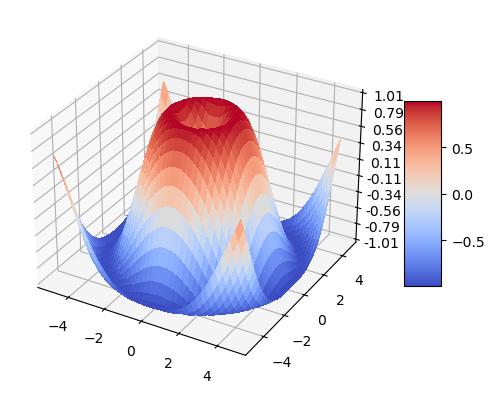

In [17]:
import matplotlib.pyplot as plt
import numpy as np


from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

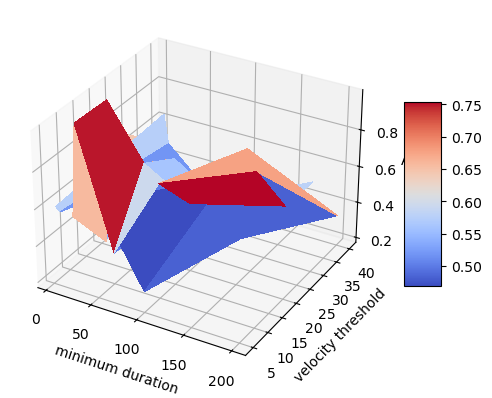

In [39]:
detection_method = 'ivt'
detection_params = helpers.get_detection_params(detection_method, sampling_rate=250)
detection_params


                      
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

if detection_method == 'ivt':
    X = np.array(list(minimum_durations))
    Y = np.array(list(velocity_thresholds))
    X, Y = np.meshgrid(X, Y)
    Z = np.random.random(X.shape)
    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    ax.set_xlabel('minimum duration')
    ax.set_ylabel('velocity threshold')
    ax.set_zlabel('AUC')
    # Customize the z axis.
    #ax.set_zlim(-1.01, 1.01)
    #ax.zaxis.set_major_locator(LinearLocator(10))
    # A StrMethodFormatter is used automatically
    #ax.zaxis.set_major_formatter('{x:.02f}')
    
    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    
    plt.show()

In [33]:
detection_params

['--minimum-duration 5 --velocity-threshold 5.0',
 '--minimum-duration 5 --velocity-threshold 10.0',
 '--minimum-duration 5 --velocity-threshold 20.0',
 '--minimum-duration 5 --velocity-threshold 30.0',
 '--minimum-duration 5 --velocity-threshold 40.0',
 '--minimum-duration 10 --velocity-threshold 5.0',
 '--minimum-duration 10 --velocity-threshold 10.0',
 '--minimum-duration 10 --velocity-threshold 20.0',
 '--minimum-duration 10 --velocity-threshold 30.0',
 '--minimum-duration 10 --velocity-threshold 40.0',
 '--minimum-duration 50 --velocity-threshold 5.0',
 '--minimum-duration 50 --velocity-threshold 10.0',
 '--minimum-duration 50 --velocity-threshold 20.0',
 '--minimum-duration 50 --velocity-threshold 30.0',
 '--minimum-duration 50 --velocity-threshold 40.0',
 '--minimum-duration 100 --velocity-threshold 5.0',
 '--minimum-duration 100 --velocity-threshold 10.0',
 '--minimum-duration 100 --velocity-threshold 20.0',
 '--minimum-duration 100 --velocity-threshold 30.0',
 '--minimum-durat

{100: 0, 5: 1, 200: 2, 10: 3, 50: 4}

In [40]:
minimum_durations

array([  5,  10,  50, 100, 200])